# JaxEM reconstruction with ASPIRE simulated data

In [1]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import numpy as np
import logging
import mrcfile
from  matplotlib import pyplot as plt
from jax.config import config
config.update("jax_enable_x64", True)
plt.rcParams["figure.figsize"]=6,6
logging.disable(logging.INFO)
logging.disable(logging.WARNING)

In [2]:
from src.projection import project_spatial
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops
from src.utils import *
from src.aspire_interface import get_params_from_aspire

from aspire.volume import Volume
from aspire.operators import FunctionFilter, RadialCTFFilter
from aspire.source import Simulation
from aspire.noise import AnisotropicNoiseEstimator

### Parameters

In [3]:
interactive = True  # Draw blocking interactive plots?
nx = 48  # Downsample the volume to a desired resolution
N = 20000  # How many images in our source.
noise_variance = 1e-5
out_dir = "../data/out_dev" # Directory to print volumes to
save_to_file = True

### Generate the simulated data

First, load ground-truth volume and downsample it.

Original volume map data shape: (1, 360, 360, 360) dtype:float64
Downsampling to (48, 48, 48)


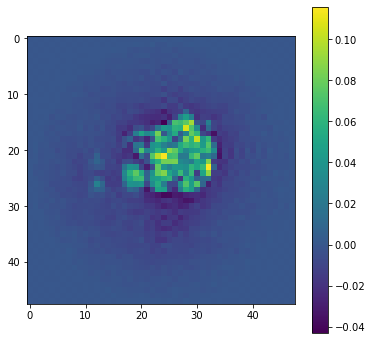

In [4]:
vol_file = "/home/bt387/project/simple_cryoem/data/emdb/emd_2660.map"
og_v = Volume.load(vol_file, dtype=np.float64)
print("Original volume map data" f" shape: {og_v.shape} dtype:{og_v.dtype}")
print(f"Downsampling to {(nx,)*3}")
v = og_v.downsample(nx)

plt.imshow(v[0,16]); plt.colorbar()

In [5]:
if save_to_file:
    with mrcfile.new(out_dir + '/v_downsampled.mrc', overwrite=True) as mrc:
        mrc.set_data(v._data.astype(np.float32))

Create the noise filter

In [6]:
# This is an example of a custom noise profile
def noise_function(x, y):
    alpha = 1
    beta = 1
    # White
    f1 = noise_variance
    # Violet-ish
    f2 = noise_variance * (x * x + y * y) / nx * nx
    return (alpha * f1 + beta * f2) / 2.0

custom_noise_filter = FunctionFilter(noise_function)

And the CTF filters

In [7]:
# Create some CTF effects
pixel_size = 5 * 65 / nx  # Pixel size of the images (in angstroms)
voltage = 200  # Voltage (in KV)
defocus_min = 1.5e4  # Minimum defocus value (in angstroms)
defocus_max = 2.5e4  # Maximum defocus value (in angstroms)
defocus_ct = 7  # Number of defocus groups.
Cs = 2.0  # Spherical aberration
alpha = 0.1  # Amplitude contrast

# Create filters
ctf_filters = [
    RadialCTFFilter(pixel_size, voltage, defocus=d, Cs=2.0, alpha=0.1)
    for d in np.linspace(defocus_min, defocus_max, defocus_ct)
]

Create the Simulation object (containing the simulated images)

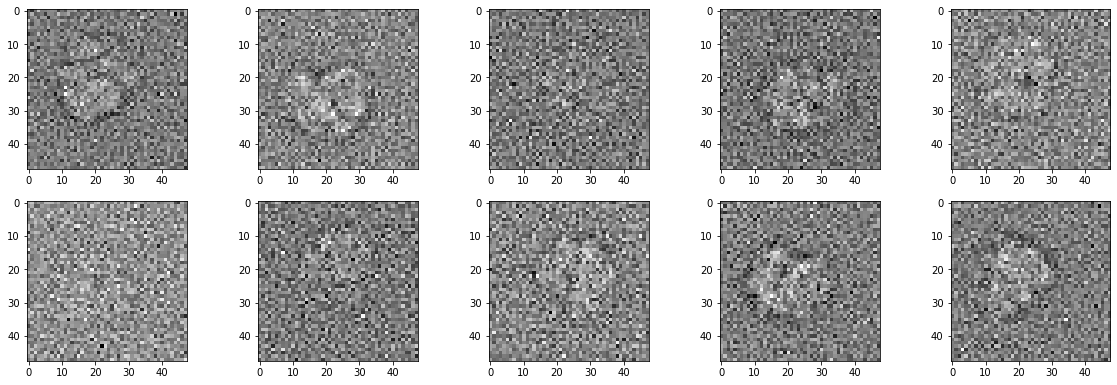

In [8]:
# Finally create the Simulation
src = Simulation(
    L=nx,
    n=N,
    vols=v,
    noise_filter= custom_noise_filter,
    unique_filters= ctf_filters
)
src.phase_flip()

# Peek
if interactive:
    src.images(0, 10).show()

Estimate the noise variance

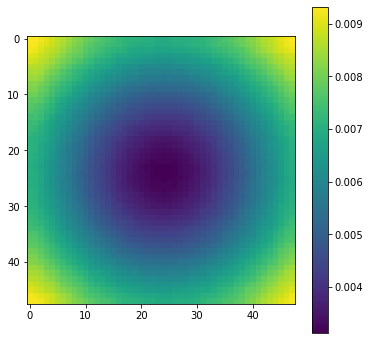

In [9]:
aiso_noise_estimator = AnisotropicNoiseEstimator(src)
sigma_noise = jnp.sqrt(aiso_noise_estimator.filter.evaluate_grid(nx))

plt.imshow(sigma_noise)
plt.colorbar()

Extract the relevant information for reconstruction

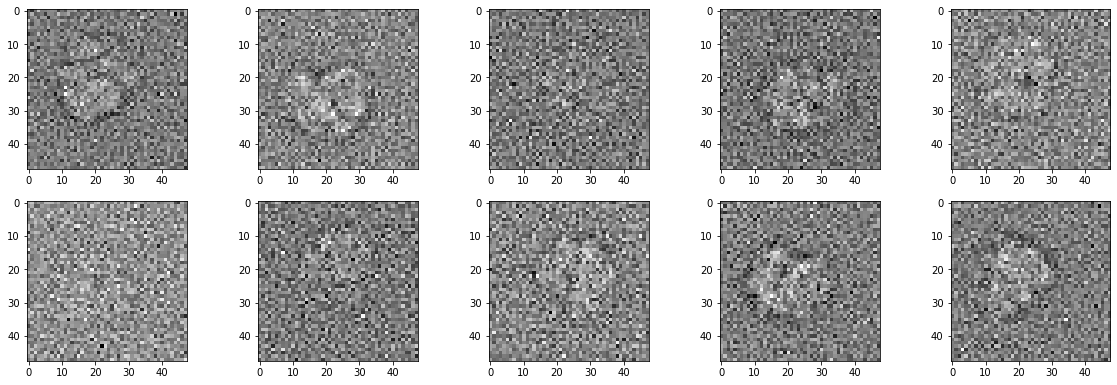

In [10]:
imgs_aspire, imgs_f_aspire, angles, shifts, ctf_params, x_grid, mask = get_params_from_aspire(src, pixel_size)

src.images(0, 10).show()

### And volume reconstruction with SGD

In [11]:
alpha = 1e-6
slice_obj = Slice(x_grid, mask)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

In [12]:
# Apply mask to iamges
imgs_f_aspire = imgs_f_aspire * mask

In [13]:
N_epochs = 20
batch_size = 100
step_size = 1e-3
grad_func = get_sgd_vol_ops(gradv_obj, angles, shifts, ctf_params, imgs_f_aspire.reshape(N,-1), sigma_noise.reshape(-1))
x0 = jnp.zeros([nx,nx,nx], dtype=jnp.complex128)

x = sgd(grad_func, N, x0, step_size, N_epochs, batch_size, verbose=True, iter_display=1)


  sgd epoch 0: mean gradient = 0.12740788537562361
  sgd epoch 1: mean gradient = 0.3631630356708872
  sgd epoch 2: mean gradient = 0.12201304880549182
  sgd epoch 3: mean gradient = 0.31861817673239845
  sgd epoch 4: mean gradient = 0.22658365166656785
  sgd epoch 5: mean gradient = 0.054306762796085005
  sgd epoch 6: mean gradient = 0.15446253832269172
  sgd epoch 7: mean gradient = 0.28262648654958866
  sgd epoch 8: mean gradient = 0.04103847913894259
  sgd epoch 9: mean gradient = 0.27849443141796615
  sgd epoch 10: mean gradient = 0.03818272277514367
  sgd epoch 11: mean gradient = 0.07324515555626855
  sgd epoch 12: mean gradient = 0.40388601989211675
  sgd epoch 13: mean gradient = 0.1201202317552353
  sgd epoch 14: mean gradient = 0.14950352412679244
  sgd epoch 15: mean gradient = 0.1688463043229322
  sgd epoch 16: mean gradient = 0.23229981063647254
  sgd epoch 17: mean gradient = 0.05540630396056147
  sgd epoch 18: mean gradient = 0.015212378798772894
  sgd epoch 19: mean gr

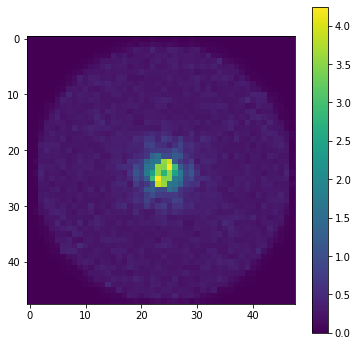

In [14]:
mip_z(jnp.fft.fftshift(jnp.abs(x))); plt.colorbar()

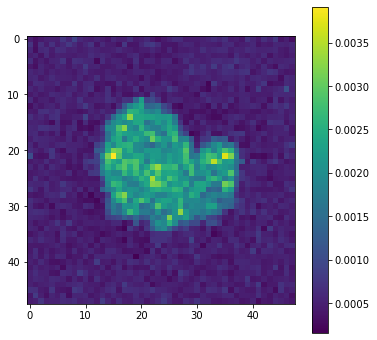

In [15]:
vol_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(x)))
mip_z(vol_rec); plt.colorbar()

In [17]:
if save_to_file:
    with mrcfile.new(out_dir + '/rec_sgd_noise.mrc', overwrite=True) as mrc:
        mrc.set_data(vol_rec.astype(np.float32))